In [1]:
import os
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

ROOT_DIR = Path(os.path.abspath(''))

from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline

MODEL_DIR = ROOT_DIR.joinpath("logs")

COCO_MODEL_PATH = str(ROOT_DIR.joinpath("mask_rcnn_coco.h5"))
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [55]:
class SofasConfig(Config):
    NAME = "sofas"

    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    NUM_CLASSES = 1 + 1  # background + 1 class (sofa)

    IMAGE_MIN_DIM = 448
    IMAGE_MAX_DIM = 448

    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128, 256)  # anchor side in pixels

    TRAIN_ROIS_PER_IMAGE = 32

    STEPS_PER_EPOCH = 200

    VALIDATION_STEPS = 10

config = SofasConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  448
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  448
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [448 448   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [56]:
def get_ax(rows=1, cols=1, size=8):
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [57]:
from PIL import Image, ImageOps

class SofasDataset(utils.Dataset):
    def load_sofas(self, count, height, width):
        self.cache = {}

        # Add classes
        self.add_class("sofas", 1, "sofa")

        # Add images
        for i in range(count):
            datadir = Path("D:/Git/NDDS Generated/TestCapturer")
            strnumber = '0' * (6 - len(str(i))) + str(i)
            path = str(datadir.joinpath(f"{strnumber}.png"))

            self.add_image(
                "sofas", 
                image_id=i, 
                path=path,
                width=width, 
                height=height,
                sofas=["sofa"])

    def load_image(self, image_id):
        image = self._load_image(image_id, '')
        return image

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        if info["source"] == "sofas":
            return info["sofas"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        sofas = info['sofas']
        count = len(sofas)
        mask = self._load_image(image_id, '.cs')
        class_ids = np.array([1 for s in sofas])
        return mask.astype(bool), class_ids.astype(np.int32)

    def _load_image(self, number, subtype):
        datadir = Path("D:/Git/NDDS Generated/TestCapturer")
        strnumber = '0' * (6 - len(str(number))) + str(number)
        path = str(datadir.joinpath(f"{strnumber}{subtype}.png"))
        if path in self.cache.keys():
            return self.cache[path]
        image = Image.open(path).convert('RGB')
        if subtype != '':
            # image = ImageOps.grayscale(image)
            data = np.asarray(image).astype(np.int32) / 255
        else:
            data = np.asarray(image).astype(np.float32)
        self.cache[path] = data
        return data

In [58]:
dataset_train = SofasDataset()
dataset_train.load_sofas(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Validation dataset
dataset_val = SofasDataset()
dataset_val.load_sofas(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

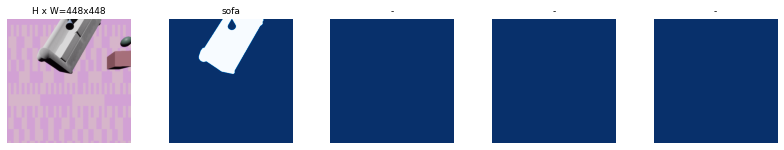

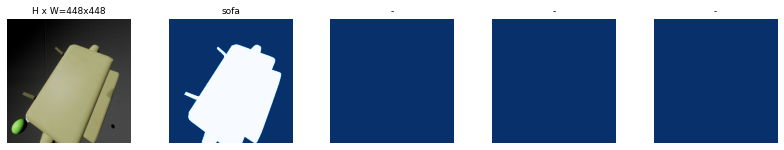

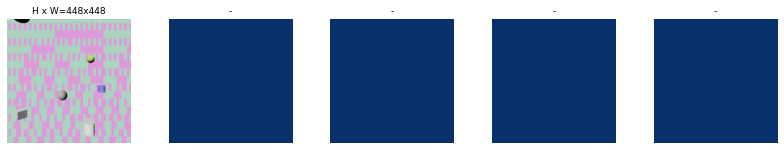

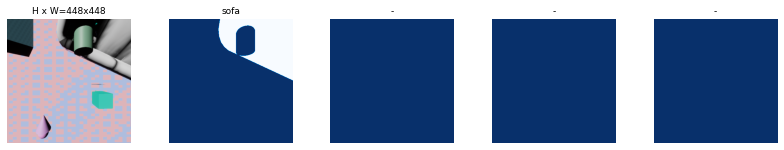

In [59]:
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [63]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

TypeError: Could not build a TypeSpec for <KerasTensor: shape=(None, None, 4) dtype=float32 (created by layer 'tf.math.truediv_3')> with type KerasTensor